# PosEmotion

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import tools.davinci as dv
import tools.metrics as ms
import pandas as pd

from rdp import rdp
from tools.detector import Detector
from tools.extractor import Extractor
from tools.structures import Skeleton

## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0


Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

# Uncomment the line below to extract frames from the videos
# extractor.extract_frames()

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a probability of a particular emotion, calculated as $i/n$, where $i$ is an emotion label and $n$ is a total number of emotions that were detected by different annotators.

In [4]:
probs = ms.label_probabilities(df)
probs_df = pd.DataFrame(probs, columns=list(ms.Emotions.keys()))
print(probs_df.shape)
probs_df.head()

(8087, 7)


,Happy,Sad,Fear,Neutral,Surprise,Disgust,Anger
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Keypoints Extraction

To extract keypoints, different approaches will be used such as YOLO-Pose, DeepPose and OpenPose. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

##### YOLO-Pose

In [5]:
def apply_yolo():    
    keypoints = []
    yolo_detector = Detector("models/yolo-pose.pt")

    for index, row in df.iterrows():
        try:
            result = yolo_detector.detect_poses("assets/frames/{}_{}.jpg".format(row["Video Tag"], index))
            keypoints.append(result.to_dict())
            print("Progress: {}/{}".format(index+1, len(df)))
        except:
            raise Exception("Error in detecting poses!")

    keypoints_df = pd.DataFrame(keypoints)
    keypoints_df.to_csv("assets/annotations/yolo_keypoints.csv", index=True)


# Uncomment the line below to apply YOLO to the frames
# apply_yolo()

yolo_df = pd.read_csv("assets/annotations/yolo_keypoints.csv")
yolo_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,803.315979,173.557571,835.515747,148.530548,783.055054,145.369812,879.411865,173.806686,757.570801,163.862640,...,695.001770,688.964600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,804.176758,173.216003,835.653809,147.682251,782.198486,145.796295,878.665039,173.041428,754.971069,165.978302,...,691.973938,694.487122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,805.239990,169.009888,836.457214,143.686768,782.505249,142.022675,877.768127,170.935852,753.729370,164.452728,...,695.380554,695.014038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,805.590393,172.032562,835.968811,146.862885,780.613586,146.146515,877.941833,173.451324,752.341492,171.449234,...,690.252319,686.663513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,787.117676,165.914810,817.990356,138.446503,763.025269,141.949539,868.388611,162.747101,740.108887,168.018570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



image 1/1 /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_0.jpg: 768x1280 1 person, 1644.6ms
Speed: 4.3ms preprocess, 1644.6ms inference, 189.8ms postprocess per image at shape (1, 3, 768, 1280)
Joints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/aJKL0ahn1Dk_0.jpg
Nose: [803.3159790039062, 173.5575714111328]
Left Eye: [835.5157470703125, 148.53054809570312]
Right Eye: [783.0550537109375, 145.36981201171875]
Left Ear: [879.411865234375, 173.8066864013672]
Right Ear: [757.57080078125, 163.86264038085938]
Left Shoulder: [929.169677734375, 346.1343078613281]
Right Shoulder: [682.93115234375, 344.57989501953125]
Left Elbow: [1042.339111328125, 553.7911376953125]
Right Elbow: [599.0847778320312, 561.6983642578125]
Left Wrist: [871.2989501953125, 508.6845703125]
Right Wrist: [605.3482055664062, 481.7702331542969]
Left Hip: [843.5042724609375, 695.0449829101562]
Right Hip: [695.0017700195312, 688.964599609375]
Left Knee: [nan, nan]
Right Knee: [nan, nan]
Lef

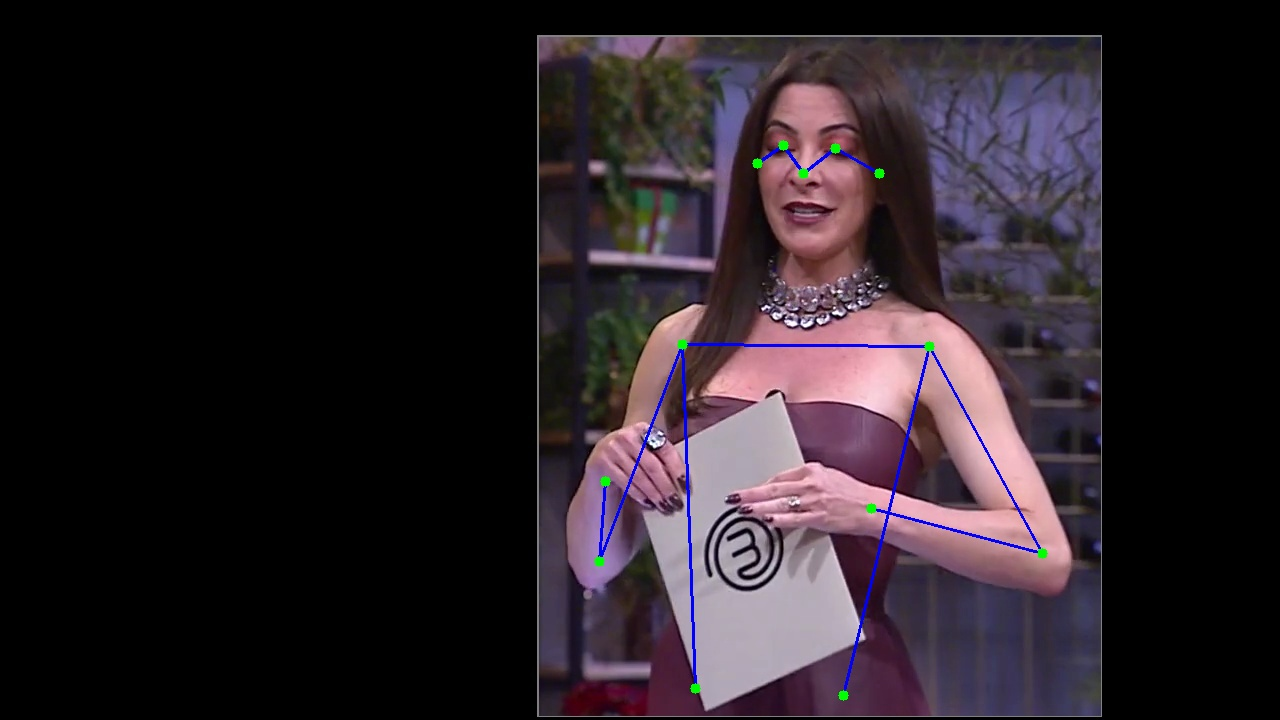

In [6]:
yolo_detector = Detector("models/yolo-pose.pt")
# result = yolo_detector.detect_poses("assets/frames/Bqb2wT_eP_4_266.jpg")
result = yolo_detector.detect_poses("assets/frames/aJKL0ahn1Dk_0.jpg")
print(result)
# dv.draw(result, inline=True)
dv.draw(result, inline=True)

##### OpenPose

##### PoseFlow

### Data Cleaning

Data cleaning is a removal of redundant segments that don't have sufficient data to be analyzed (people with not enough joints detected). The necessary body parts will be determined as torso, left and right hands. The frames that don't satisfy those criterias, will be removed from the DataFrame.

In [7]:
annotated_df = pd.read_csv("assets/annotations/yolo_annotations.csv")

# Remove all columns that represent legs
# columns_drop = annotated_df.columns[annotated_df.columns.get_loc('right_hip_Y')+1:]
# annotated_df = annotated_df.drop(columns=columns_drop)

# Remove rows that have NaN values in all necessary body parts
# body_parts = annotated_df.columns[annotated_df.columns.get_loc('right_ear_Y')+1:]
# annotated_df = annotated_df.dropna(subset=body_parts, how='any')
# annotated_df = annotated_df.reset_index(drop=True)
# print(annotated_df.shape)
# annotated_df.head()

### Data Augmentation

It can happen that there is not enough data to have accurate clustering results. In that case data can be augmented by "mirroring" frames around $y$-axis. Because it is mirrored pose, it technically will be considered as a different one by detecting algorithms, but will be still accurate related to emotions, because human's bodies are mostly simmetrical. It should create a duplicate for each frame and, therefore, increase the number of frames twice.

### Normalization

##### Segment Normalization

To normalize each segment, we need to normalize their sizes:
- If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
- If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
- If the size of a segment $s = x$, then segment normalization won't be applied.

In [8]:
segments = ms.segmentate(annotated_df)
print("Total number of segments:", len(segments))
print("Original (first 5):", [segment.indices() for segment in segments][:5])

norm_segments = [ms.normalize_segment(segment) for segment in segments]
norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)

norm_segments = ms.segmentate(norm_df)
print("Total number of normalized segments:", len(norm_segments))
print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

Total number of segments: 630
Original (first 5): [(0, 27), (28, 39), (40, 51), (52, 69), (70, 77)]
Total number of normalized segments: 630
Normalized (first 5): [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49)]


##### Skeleton Normalization

At first, not all skeletons, detected on the images, have consistent position relative to the camera. Some people stand and look directly to the camera, some tilted by some unknown angle $\alpha$ around $y$-axis, so only their projection is seen on $xz$ plane; others may stand with their back. For that purpose, it may needed to rotate the skeletons around $y$-axis. However, because there is no depth information in 2D images and only $(x,y)$ coordinates given for skeleton, the NAME will be used to estimate $z$ coordinate of each pixel on the image. Then detected pixels will be aligned with existing joints coordinates and new Keypoints object with $(x,y,z)$ coordinates will be created as an output for each frame.

According to [Romero Moralis](https://openaccess.thecvf.com/content_CVPR_2019/html/Morais_Learning_Regularity_in_Skeleton_Trajectories_for_Anomaly_Detection_in_Videos_CVPR_2019_paper.html), in 2D image space, $xy$-coordinates alone poorly represent the real location in the scene because the depth is missing. However, the size of a skeleton’s bounding box is correlated with the skeleton’s depth in the scene. To bridge this gap, the skeleton's bounding box can be used (that in our case was already given in dataset) with parameters $f^g = (x^g, y^g, w, h)$ and used to normalize the local components $f^{l,i} = (x^{l,i}, y^{l,i})$. 

In [11]:
norm_skeletons = []

for index, row in norm_df.iterrows():
    start_label = "nose_X"
    row_truncated = row.loc[start_label:]
    box = (row["X"], row["Y"], row["Width"], row["Height"])
    skeleton = Skeleton.from_series(row)
    norm_skeleton = ms.normalize_skeleton(skeleton, box)
    print(norm_skeleton)
    break
    # norm_skeletons.append(norm_skeleton.to_dict())

AttributeError: 'Skeleton' object has no attribute 'to_list'

## Step 2: Feature Extraction

### Skeleton Trajectory Features

To extract trajectory features, inspired by [Tomasz Sapiński](https://www.mdpi.com/1099-4300/21/7/646), the curve simplification (CS) algorithm, based on the Lowe's algorithm, will be applied, for 2D joints separately for each segment, that returns a set of key points that are essential for accurately representing the original curve. The algorithm will return the following:
 
- The critical frames in the motion sequence that capture significant changes in the movement.
- The simplified version of the original motion trajectory (data reduction).
- The maximum deviation error for each segment of the simplified trajectory, ensuring that the simplification process maintains a level of accuracy defined by the error threshold.

## Step 3: Clustering

### Hierarchical

### X-Means

## Step 4: Emotion Label Association

### Associate Poses with Emotions

## Step 5: Evaluation and Refinement

### Evaluate Clusters

### Refine Clusters